In [65]:
import torch
import math
import numpy as np
import matplotlib.pyplot as plt

In [66]:
def SimulateHestonBrownianMotion(S0,r,K,theta,sigma,sigma0,rho,T,N,nbSimulation):
    dt=T/N

    mu=np.array([0,0])
    cov=np.array([[1,rho],[rho,1]])

    S=np.full(shape=(N,nbSimulation),fill_value=S0)
    v=np.full(shape=(N,nbSimulation),fill_value=sigma0)

    Z=np.random.multivariate_normal(mu,cov,(N,nbSimulation))

    for i in range(N-1):


        v_current = np.maximum(v[i], 1e-8)
        S[i+1]=S[i]*np.exp(  ( r - v_current/2 ) * dt + np.sqrt( v_current * dt ) * Z[i,:,0])
        v[i+1]=np.maximum( (v[i] + K * ( theta - v[i] ) *dt + sigma * np.sqrt(v_current ) *np.sqrt(dt)* Z[i,:,1]) , 0)
    
    return S,v

In [67]:
np.random.seed(42)  # Pour reproductibilité

S0 = 100.0
r = 0.05
K = 2.0
theta = 0.04
sigma = 0.3
sigma0 = 0.04
rho = -0.7
T = 1.0
N = 252
nbSimulation = 5000

In [68]:
S,v=SimulateHestonBrownianMotion(S0,r,K,theta,sigma,sigma0,rho,T,N,nbSimulation)

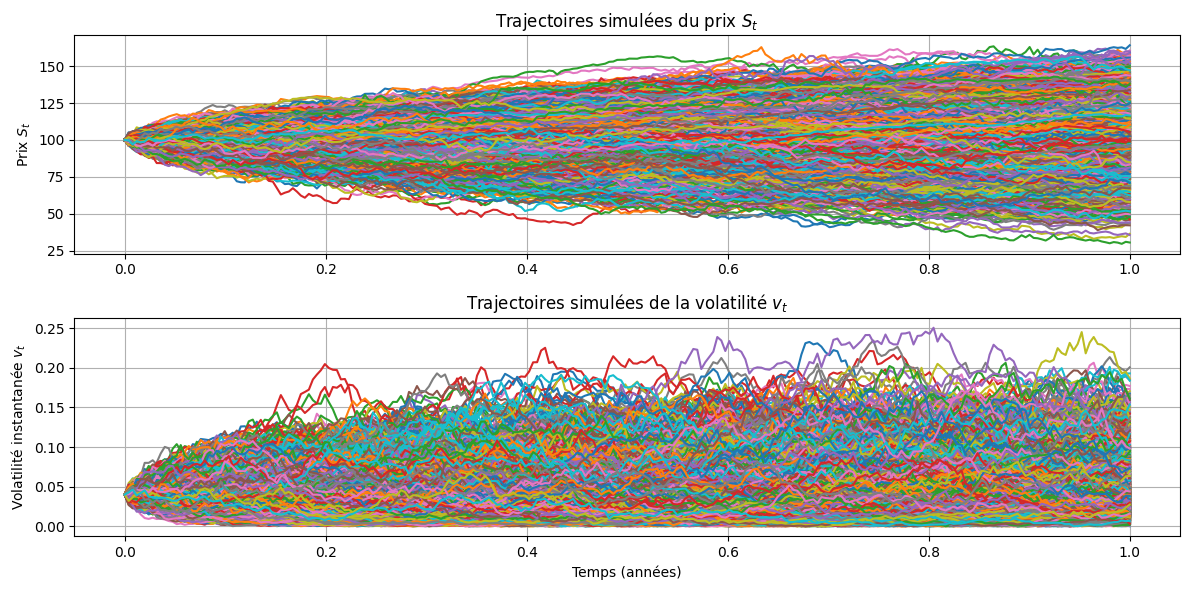

In [69]:
# --- Tracé ---
t = np.linspace(0, T, N)

plt.figure(figsize=(12, 6))

# Graphique 1 : Prix S_t
plt.subplot(2, 1, 1)
plt.plot(t, S)
plt.title("Trajectoires simulées du prix $S_t$")
plt.ylabel("Prix $S_t$")
plt.grid(True)

# Graphique 2 : Volatilité v_t
plt.subplot(2, 1, 2)
plt.plot(t, v)
plt.title("Trajectoires simulées de la volatilité $v_t$")
plt.xlabel("Temps (années)")
plt.ylabel("Volatilité instantanée $v_t$")
plt.grid(True)

plt.tight_layout()
plt.show()

In [70]:
import torch
import numpy as np

def MonteCarlosEuCallOptionHeston(S0,r,K,Kappa,theta,sigma,sigma0,rho,T,N,nbSimulation):

    S,v=SimulateHestonBrownianMotion(S0,r,Kappa,theta,sigma,sigma0,rho,T,N,nbSimulation)

    CallPayoff = np.maximum(S[-1, :] - K, 0)

    price=np.exp(-r*T)*np.mean(CallPayoff)

    return price


In [71]:
np.random.seed(42)
callprice=MonteCarlosEuCallOptionHeston(S0,r,100,K,theta,sigma,sigma0,rho,T,N,nbSimulation)

In [72]:
print(callprice)

10.331436547237285


In [73]:
import numpy as np
import math
from scipy.stats import norm

def BlackScholesCallPricing(S,K,tau,sigma,r):
    if tau <= 0: 
        return max(0.0, S-K)
    d1 = (math.log(S/K) + (r + 0.5*sigma**2)*tau)/(sigma*math.sqrt(tau))
    d2 = d1 - sigma*math.sqrt(tau)
    return S*norm.cdf(d1) - K*math.exp(-r*tau)*norm.cdf(d2)
    

In [76]:
bsPrice=BlackScholesCallPricing(S0,100,T,np.sqrt(theta),r)

In [77]:
print(bsPrice)

10.450583572185565


In [13]:
import yfinance as yf

# Récupérer les données ^IRX
irx = yf.Ticker("^IRX")

# Prix actuel
prix_actuel = irx.info['regularMarketPrice']
print(f"Prix actuel ^IRX: {prix_actuel}%")



Prix actuel ^IRX: 3.763%


In [2]:
import yfinance as yf
ticker = yf.Ticker("AAPL")
opt_dates = ticker.options  
opt_chain = ticker.option_chain(opt_dates[0])  
calls = opt_chain.calls

In [15]:
print(calls)

         contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0   AAPL251031C00125000 2025-10-24 18:09:01+00:00   125.0     139.03  136.95   
1   AAPL251031C00140000 2025-10-16 13:34:11+00:00   140.0     107.52  122.05   
2   AAPL251031C00150000 2025-10-24 19:52:35+00:00   150.0     113.37  112.05   
3   AAPL251031C00155000 2025-10-23 18:14:36+00:00   155.0     105.37  107.00   
4   AAPL251031C00160000 2025-10-21 19:56:42+00:00   160.0     101.80  102.05   
5   AAPL251031C00165000 2025-10-23 15:20:06+00:00   165.0      94.30   97.00   
6   AAPL251031C00170000 2025-10-24 15:56:10+00:00   170.0      92.86   92.05   
7   AAPL251031C00175000 2025-10-23 13:52:03+00:00   175.0      84.30   87.00   
8   AAPL251031C00180000 2025-10-24 18:33:19+00:00   180.0      84.05   82.05   
9   AAPL251031C00185000 2025-10-24 17:22:53+00:00   185.0      78.66   77.00   
10  AAPL251031C00190000 2025-10-24 13:39:43+00:00   190.0      70.11   72.10   
11  AAPL251031C00195000 2025-10-24 19:21

In [8]:
import pandas as pd

data = []
for date in opt_dates[:20]:  # prenons les 5 premières maturités
    chain = ticker.option_chain(date)
    calls = chain.calls
    calls['expiration'] = date
    data.append(calls[['strike', 'impliedVolatility', 'expiration']])

vol_data = pd.concat(data)


In [9]:
from datetime import datetime

today = datetime.today()
vol_data['T'] = vol_data['expiration'].apply(lambda d: (datetime.strptime(d, "%Y-%m-%d") - today).days / 365)


In [10]:
import numpy as np

strikes = vol_data['strike'].values
Ts = vol_data['T'].values
vols = vol_data['impliedVolatility'].values


In [11]:
from scipy.interpolate import griddata

K_grid = np.linspace(min(strikes), max(strikes), 80)
T_grid = np.linspace(min(Ts), max(Ts), 40)
K_mesh, T_mesh = np.meshgrid(K_grid, T_grid)

IV_surface = griddata((Ts, strikes), vols, (T_mesh, K_mesh), method='cubic')


In [24]:
import plotly.graph_objects as go
import plotly.io as pio

# Crée la surface 3D interactive
fig = go.Figure(
    data=[go.Surface(
        x=T_mesh,          # Maturités
        y=K_mesh,          # Strikes
        z=IV_surface,      # Volatilités implicites
        colorscale='Viridis',
        opacity=0.9
    )]
)

# Mise en forme des axes et du titre
fig.update_layout(
    title="Surface de volatilité implicite - AAPL (marché)",
    scene=dict(
        xaxis_title="Maturité T (années)",
        yaxis_title="Strike K",
        zaxis_title="Volatilité implicite",
    ),
    width=1000,
    height=800,
    margin=dict(l=0, r=0, b=0, t=50)
)

pio.renderers.default = "browser"
fig.show()